### Problem 2, part (d) numerical experiments

Let's do some experiments with random matrices to investigate the "average case" loss of orthogonality when CholsekyQR is applied to ill-conditioned matrices. Here is our ill-conditioned matrix with condition number $\kappa(X)$.



In [1]:
using LinearAlgebra
using Plots


function randMat(m, n, kap)
    m = Int(m)          # number of rows
    n = Int(n)          # number of columns
    QR1 = qr(randn(m,n))
    QR2 = qr(randn(n,n))
    return QR1.Q * diagm(10 .^ (range(0,stop = log10(kap), length = n))) * QR2.Q
end 

X = randMat(1e4, 100, 1e6)
cond(X)

999999.9999993553

We'll run our Cholesky QR on a rage of random matrices with condition numbers between 1 and $\kappa_{max}$, and see how the loss of orthogonality scales. We'll also check the residual $\|X - \hat Q\hat R\|$ of the computed factorization.

In [2]:

function choleskyQR( X )
    A = X' * X
    F = cholesky(A)
    R = F.U
    Q = X / R

    return (Q, R)
end

m = 1e4
n = 100
kap_max = 1e8
kap = 10 .^ (range(0, stop = log10(kap_max), length = n))
errs = zeros(length(kap))
res = zeros(length(kap))
for k = 1:length(kap)
    X = randMat(m, n, kap[k])
    Q, R = choleskyQR( X )
    errs[k] = norm(I - Q' * Q)
    res[k] = norm(X - Q*R)
end

Here's the plots in a separate cell, since the above code takes a few seconds to run every time.

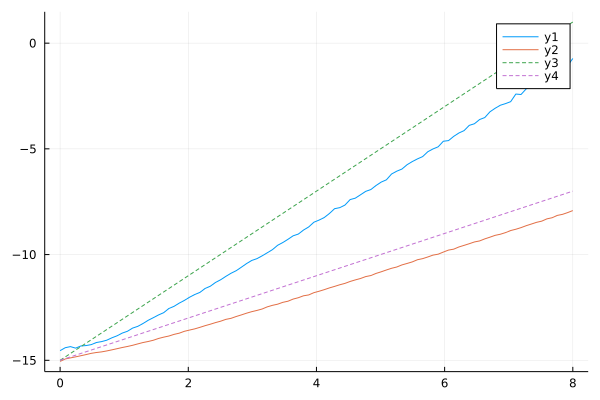

In [3]:
plot(log10.(kap), log10.(errs))
plot!(log10.(kap), log10.(res))

plot!(log10.(kap), -15*ones(length(kap)) + 2*log10.(kap), linestyle = :dash)
plot!(log10.(kap), -15*ones(length(kap)) + log10.(kap), linestyle = :dash)

The loss of orthogonality seems to scale with $\kappa(X)^2$, while the residual seems to scale linearly in $\kappa(X)$. So, at least for these random matrices, things are not quite as bad as the worst case first-order estimates we derived. In fact, these experiment results echo similar experiments for classical Gram-Schmidt.

We can actually do better, if we're willing to rerun CholeskyQR for a second time with the orthogonal factor.

In [4]:
m = 1e4
n = 100
kap_max = 1e8
kap = 10 .^ (range(0, stop = log10(kap_max), length = n))
errs = zeros(length(kap))
res = zeros(length(kap))
for k = 1:length(kap)
    X = randMat(m, n, kap[k])
    Q, R1 = choleskyQR( X )
    Q, R2 = choleskyQR( Q )
    R = R2*R1
    errs[k] = norm(I - Q' * Q)
    res[k] = norm(X - Q*R)
end

The residual still scales linearly with the condition number, but the loss of orthogonality in the computed orthogonal factor stays level at machine precision! This "twice-is-enough" phenomenon is also present in classical Gram-Schmidt.

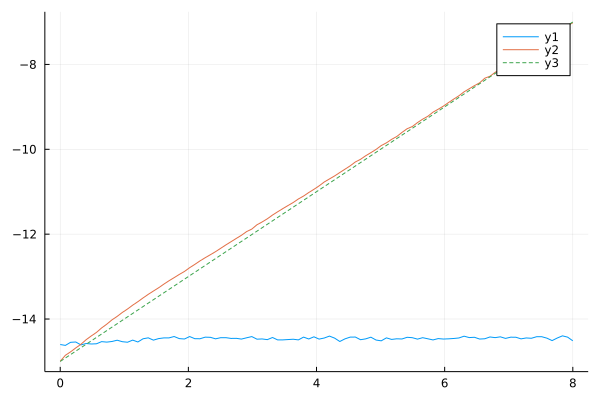

In [5]:
plot(log10.(kap), log10.(errs))
plot!(log10.(kap), log10.(res))

#plot!(log10.(kap), -15*ones(length(kap)) + 2*log10.(kap), linestyle = :dash)
plot!(log10.(kap), -15*ones(length(kap)) + log10.(kap), linestyle = :dash)

### Problem 3

This notebook walks through stage (i) of the QZ algorithm. Here are our test matrices $A$ and $B$.

In [6]:
using LinearAlgebra

n = 5
A = rand(n,n)
B = rand(n,n)
display(A)
display(B)

5×5 Matrix{Float64}:
 0.983606  0.344959  0.884078  0.712777  0.574054
 0.19869   0.28206   0.607912  0.503201  0.739231
 0.584267  0.641084  0.211871  0.238809  0.823153
 0.95831   0.940691  0.786385  0.172457  0.999495
 0.185496  0.989791  0.113607  0.921889  0.832411

5×5 Matrix{Float64}:
 0.660378  0.313957  0.0353686  0.96814   0.766373
 0.382204  0.96719   0.816787   0.234952  0.481904
 0.188105  0.583342  0.112909   0.393121  0.487283
 0.32888   0.647862  0.0990184  0.807656  0.744365
 0.205912  0.557143  0.525649   0.834802  0.593981

We'll be using Householder transformations throughout, so here is the code that calculates and applies Householder transformations, taken from the implicit_QR notebook in the course notes.

In [7]:
# get reflector for Householder transformation
function reflector( x )
    v = zeros(length(x))
    v[1] = sign(x[1]) * norm(x) + x[1]
    v[2:end] = x[2:end] 
    v = v / norm(v)
    return v
end

# apply Householder transformation to A from left, i.e., QA = (I-vv')A 
function hhtLeft( A, v)
    return A - 2 * v * (transpose(v) * A)
end

# apply Householder transformation to A from right, i.e., AQ = A(I-vv') 
function hhtRight( A, v)
    return A - 2 * (A * v) * transpose(v)
end

hhtRight (generic function with 1 method)

### Part (a)

First, we need to apply Householder transformations on the left of $A$ and $B$ with the goal of triangularizing $B$. We can accomplish this using Householder QR to compute $R = Q^TB$, and then applying the same transformation to $A$. Note that we always need to apply the same orthogonal transformations to $A$ and $B$ so that the generalized eigenvalues don't change: if $Av=\lambda Bv$ then $Q^TA= \lambda Q^TBv =\lambda Rv$.

In [8]:
# Householder QR using LinearAlgebra.QR
QR = qr(B)
R = QR.R 
AA=QR.Q'*A

# check structure of R and Q'*A
display(R)
display(AA)

# check that generalized eigenvalues haven't changed
[eigen(AA,R).values eigen(A,B).values]

5×5 Matrix{Float64}:
 -0.876427  -1.15756   -0.567734  -1.41552   -1.31107
  0.0       -0.874361  -0.648227  -0.126177  -0.327661
  0.0        0.0        0.474059  -0.202744  -0.200541
  0.0        0.0        0.0       -0.659932  -0.312059
  0.0        0.0        0.0        0.0        0.00595277

5×5 Matrix{Float64}:
 -1.35637     -1.10606    -1.29851    -1.08907   -1.50222
  0.00465366  -0.726978   -0.0672387  -0.245283  -0.855237
 -0.657301    -0.360292   -0.192977    0.395615  -0.32419
 -0.158841    -0.769571    0.111639   -0.482938  -0.386596
 -0.0636694    0.0144591  -0.294969    0.24885    0.0532052

5×2 Matrix{ComplexF64}:
 -20.6371+0.0im      -20.6371+0.0im
 -1.54779+0.0im      -1.54779+0.0im
  1.10013+0.0im       1.10013+0.0im
  1.39326-1.27139im   1.39326+1.27139im
  1.39326+1.27139im   1.39326-1.27139im

Householder QR triangularizes $B$ one column at a time, from left to right: see Lecture 10 in the textbook for the diagrams. The matrix $A$ generically remains dense, as no strategic new zeros are introduced (and any preexisting zeros in $A$ may be destroyed by applying $Q^T$).



### Part (b)

Now, the challenge is to apply a further sequence of Householder transformations on the left and the right of $B$ to reduce $A$ to upper Hessenberg form while keeping $B$ upper triangular. Again, the same transformations applied to the left or right of $A$ need to be applied to $B$ to preserve the generalized eigenvalues: if $Av = \lambda Bv$, then $AQw = \lambda BQw$ where $v=Qw$.

Let's begin transforming $Q^TA$ to upper Hessenberg form by introducing zeros in its first column. We'll  use a $2\times 2$ Householder transformation from the left that mixes the last two rows of $R$. When we apply the same transformations to $R$, one nonzero appears below the diagonal in the second to last column.

In [9]:
# copy matrices to new cell block - looks weird but is a quick fix for a display issue
R = copy(R)
H = copy(AA)

# orthogonal transforms from the left introduces zeros in first column below first subdiagonal of Q'*A
v = reflector(H[end-1:end,1])
H[end-1:end,:] = hhtLeft(H[end-1:end,:], v)
R[end-1:end,:] = hhtLeft(R[end-1:end,:], v)

display(H)
display(R)

5×5 Matrix{Float64}:
 -1.35637     -1.10606   -1.29851     -1.08907   -1.50222
  0.00465366  -0.726978  -0.0672387   -0.245283  -0.855237
 -0.657301    -0.360292  -0.192977     0.395615  -0.32419
  0.171126     0.708942   0.00612167   0.355679   0.339046
  0.0          0.299748  -0.315329     0.410667   0.193223

5×5 Matrix{Float64}:
 -0.876427  -1.15756   -0.567734  -1.41552   -1.31107
  0.0       -0.874361  -0.648227  -0.126177  -0.327661
  0.0        0.0        0.474059  -0.202744  -0.200541
  0.0        0.0        0.0        0.612554   0.287441
  0.0        0.0        0.0        0.245535   0.12163

We have successfully introduced a zero in the bottom left corner of $Q^TA$, but a nonzero has appeared below the second to last diagonal entry of $R$. We can apply a $2\times 2$ Householder transformation from the left that mixes the last two columns to eliminate this subdiagonal entry. When we apply the same transformation to $Q^TA$, the zero we introduced during the previous transformation from the right is not affected because we only mix the last two columns.

In [10]:
# copy matrices to new cell block - looks weird but is a quick fix for a display issue
R = copy(R)
H = copy(H)

# orthogonal transform form left restores upper triangular structure in R w/out affecting new zeros in Q^TA
v = reflector(reverse(transpose(R[end,end-1:end])))
H[:,end-1:end] = hhtRight(H[:,end-1:end], reverse(v))
R[:,end-1:end] = hhtRight(R[:,end-1:end], reverse(v))

display(H)
display(R)

5×5 Matrix{Float64}:
 -1.35637     -1.10606   -1.29851      0.86268      1.64272
  0.00465366  -0.726978  -0.0672387    0.657482     0.599425
 -0.657301    -0.360292  -0.192977     0.46611     -0.210598
  0.171126     0.708942   0.00612167  -0.14593     -0.469217
  0.0          0.299748  -0.315329     0.00914832  -0.453761

5×5 Matrix{Float64}:
 -0.876427  -1.15756   -0.567734  0.546485      1.8504
  0.0       -0.874361  -0.648227  0.237602      0.258511
  0.0        0.0        0.474059  0.0897052     0.270693
  0.0        0.0        0.0       0.0143368    -0.676491
  0.0        0.0        0.0       2.77556e-17  -0.27401

Let's introduce the next zero in the first column of $Q^TA$ with another $2\times 2$ Householder transformation.

In [11]:
# copy matrices to new cell block - looks weird but is a quick fix for a display issue
R = copy(R)
H = copy(H)

# orthogonal transforms from the left introduces zeros in first column below first subdiagonal of Q'*A
v = reflector(H[end-2:end-1,1])
H[end-2:end-1,:] = hhtLeft(H[end-2:end-1,:], v)
R[end-2:end-1,:] = hhtLeft(R[end-2:end-1,:], v)

display(H)
display(R)

5×5 Matrix{Float64}:
 -1.35637     -1.10606   -1.29851     0.86268      1.64272
  0.00465366  -0.726978  -0.0672387   0.657482     0.599425
  0.679212     0.527286   0.188294   -0.48784      0.0855865
  0.0          0.595298  -0.042696   -0.0237863   -0.50714
  0.0          0.299748  -0.315329    0.00914832  -0.453761

5×5 Matrix{Float64}:
 -0.876427  -1.15756   -0.567734   0.546485      1.8504
  0.0       -0.874361  -0.648227   0.237602      0.258511
  0.0        0.0       -0.458766  -0.0831993    -0.432402
  0.0        0.0        0.119438   0.0364754    -0.586467
  0.0        0.0        0.0        2.77556e-17  -0.27401

Mixing the 2nd and 3rd from last rows of $R$ introduces another nonzero belwow the diagonal, this time in the column 3rd from last. We can apply a $2\times 2$ Householder from the left that mixes the 2nd and 3rd from last columns to zero this entry out, without effecting the zeros in the first column of $Q^TA$.

In [12]:
# copy matrices to new cell block - looks weird but is a quick fix for a display issue
R = copy(R)
H = copy(H)

# orthogonal transform form left restores upper triangular structure in R w/out affecting new zeros in Q^TA
v = reflector(reverse(transpose(R[end-1,end-2:end-1])))
H[:,end-2:end-1] = hhtRight(H[:,end-2:end-1], reverse(v))
R[:,end-2:end-1] = hhtRight(R[:,end-2:end-1], reverse(v))

display(H)
display(R)

5×5 Matrix{Float64}:
 -1.35637     -1.10606   -1.20432     0.989917    1.64272
  0.00465366  -0.726978  -0.648452   -0.127727    0.599425
  0.679212     0.527286   0.521564   -0.0375978   0.0855865
  0.0          0.595298   0.0102787   0.0477817  -0.50714
  0.0          0.299748  -0.100849    0.298907   -0.453761

5×5 Matrix{Float64}:
 -0.876427  -1.15756   -0.688477      0.383363     1.8504
  0.0       -0.874361  -0.416572      0.550564     0.258511
  0.0        0.0       -0.0544225     0.463062    -0.432402
  0.0        0.0        0.0          -0.124884    -0.586467
  0.0        0.0       -2.65453e-17  -8.1067e-18  -0.27401

We can continue in this manner moving up along the first column introducing zeros in $Q^TA$ with a $2\times 2$ Householder transformation on the left, and then eliminating the corresponding nonzero entries introduced in $R$ with a $2\times 2$ Householder transformation applied from the right.

In [13]:
R = copy(R)
H = copy(H)

for j = 3:n-2
    # orthogonal transforms from the left introduces zeros in first column below first subdiagonal of Q'*A
    v = reflector(H[end-j:end-j+1,1])
    H[end-j:end-j+1,:] = hhtLeft(H[end-j:end-j+1,:], v)
    R[end-j:end-j+1,:] = hhtLeft(R[end-j:end-j+1,:], v)

    # orthogonal transform form left restores upper triangular structure in R w/out affecting new zeros in Q^TA
    v = reflector(reverse(transpose(R[end-j+1,end-j:end-j+1])))
    H[:,end-j:end-j+1] = hhtRight(H[:,end-j:end-j+1], reverse(v))
    R[:,end-j:end-j+1] = hhtRight(R[:,end-j:end-j+1], reverse(v))
end
display(H)
display(R)



5×5 Matrix{Float64}:
 -1.35637    0.612035   1.51631   0.989917    1.64272
 -0.679228   0.242432   0.693843  0.038472   -0.0896914
  0.0       -0.274719  -0.939885  0.127467   -0.598825
  0.0        0.246576  -0.541927  0.0477817  -0.50714
  0.0        0.21989   -0.227306  0.298907   -0.453761

5×5 Matrix{Float64}:
 -0.876427   0.12413       1.34109       0.383363     1.8504
  0.0       -0.0491406    -0.0300258    -0.466823     0.43062
  0.0        2.22045e-16  -0.968341     -0.547378    -0.261467
  0.0        0.0           0.0          -0.124884    -0.586467
  0.0        2.39684e-17   1.14091e-17  -8.1067e-18  -0.27401

Once all but the first two entries in the first column of $Q^TA$ are zero, and $R$ has been transformed to a new triangular matrix, we can repeat the process for each column until $Q^TA$ has been transformed to upper Hessenberg  form and $R$ has been transformed to yet another new triangular matrix.

In [14]:
R = copy(R)
H = copy(H)

for k = 2:n-2           # for each column (left to right)...
    for j = 1:n-k-1      # for each row (bottom to first subdiagonal)...
        # orthogonal transforms from the left introduces zeros in first column below first subdiagonal of Q'*A
        v = reflector(H[end-j:end-j+1,k])
        H[end-j:end-j+1,:] = hhtLeft(H[end-j:end-j+1,:], v)
        R[end-j:end-j+1,:] = hhtLeft(R[end-j:end-j+1,:], v)

        # orthogonal transform form left restores upper triangular structure in R w/out affecting new zeros in Q^TA
        v = reflector(reverse(transpose(R[end-j+1,end-j:end-j+1])))
        H[:,end-j:end-j+1] = hhtRight(H[:,end-j:end-j+1], reverse(v))
        R[:,end-j:end-j+1] = hhtRight(R[:,end-j:end-j+1], reverse(v))
    end
end
display(H)
display(R)

5×5 Matrix{Float64}:
 -1.35637    0.612035      0.158155   -0.799557   2.30507
 -0.679228   0.242432      0.106076   -0.671727   0.168743
  0.0        0.429676     -0.0988813  -0.222836  -0.0138793
  0.0        4.70819e-17  -0.85406     0.568485  -0.943163
  0.0       -6.28193e-17   0.0        -0.273364   0.28599

5×5 Matrix{Float64}:
 -0.876427   0.12413       0.731568     -0.507174      2.1394
  0.0       -0.0491406     0.574797      0.238677      0.130006
  0.0       -1.29701e-16  -0.21151      -0.711645      0.0738086
  0.0        1.81639e-16   1.1211e-16    0.481358     -0.919804
  0.0       -7.93891e-18  -3.14519e-19  -1.38778e-17   0.325463

We can now collect the full code for stage (i) into a function and run it on a larger test problem.

In [15]:
# reduce A and B to upper Hessenberg and triangular form by Householder reflections for QZ stage (i)
function stage1QZ( A, B)
    
    # Part (a), triangularize B and apply the orthogonal transform to A
    QR = qr(B)
    R = QR.R 
    H=QR.Q'*A

    # Part (b), reduce Q^TA to Hessenberg while maintaining triangular form of R
    for k = 1:n-2           # for each column (left to right)...
        for j = 1:n-k-1      # for each row (bottom to first subdiagonal)...
            # orthogonal transforms from the left introduces zeros in first column below first subdiagonal of Q'*A
            v = reflector(H[end-j:end-j+1,k])
            H[end-j:end-j+1,:] = hhtLeft(H[end-j:end-j+1,:], v)
            R[end-j:end-j+1,:] = hhtLeft(R[end-j:end-j+1,:], v)
    
            # orthogonal transform form left restores upper triangular structure in R w/out affecting new zeros in Q^TA
            v = reflector(reverse(transpose(R[end-j+1,end-j:end-j+1])))
            H[:,end-j:end-j+1] = hhtRight(H[:,end-j:end-j+1], reverse(v))
            R[:,end-j:end-j+1] = hhtRight(R[:,end-j:end-j+1], reverse(v))
        end
    end

    # Return upper Hessenberg and triangular factors
    return (H,R)
end

# new test matrices
n = 25
A = rand(n,n)
B = rand(n,n)
H, R = stage1QZ( A, B)

# check structure of H and R (norm of departure from upper Hessenberg and upper triangular)
display(norm(UpperHessenberg(H)-H))
display(norm(UpperTriangular(R)-R))

# check generalized eigenvalues are preserved
display([eigen(A,B).values eigen(H,R).values])



2.5425531363828366e-15

2.7857504427938805e-15

25×2 Matrix{ComplexF64}:
   -4.86971+0.0im          -4.86971+0.0im
   -2.43084-4.14648im      -2.43084-4.14648im
   -2.43084+4.14648im      -2.43084+4.14648im
   -1.73682+0.0im          -1.73682+0.0im
  -0.987751-1.94593im     -0.987751-1.94593im
  -0.987751+1.94593im     -0.987751+1.94593im
  -0.736296+0.0im         -0.736296+0.0im
  -0.423759+0.0im         -0.423759+0.0im
  -0.240823-0.195608im    -0.240823-0.195608im
  -0.240823+0.195608im    -0.240823+0.195608im
  -0.134334-0.396547im    -0.134334+0.396547im
  -0.134334+0.396547im    -0.134334-0.396547im
 -0.0499163-0.616188im   -0.0499163-0.616188im
 -0.0499163+0.616188im   -0.0499163+0.616188im
   0.448781-0.266889im     0.448781+0.266889im
   0.448781+0.266889im     0.448781-0.266889im
   0.594705-0.387075im     0.594705-0.387075im
   0.594705+0.387075im     0.594705+0.387075im
   0.704839-1.0967im       0.704839-1.0967im
   0.704839+1.0967im       0.704839+1.0967im
   0.871932-0.0840992im    0.871932-0.0840992im
   0.871932+0.0